# Import required modules

In [1]:
%%time

# ipython kernel install --user --name=venv
!pip install -qU requests opencv-python numpy pandas scikit-learn tensorflow==2.5.0
import os
import cv2
import glob
import random
import pickle
import pandas
import requests

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.python.layers.layers import flatten
from sklearn.utils import shuffle
tf.disable_v2_behavior()

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.
Instructions for updating:
non-resource variables are not supported in the long term
CPU times: user 5.84 s, sys: 1.18 s, total: 7.02 s
Wall time: 17.8 s


# Download dataset

In [2]:
%%time

FILES = ['test.p', 'train.p', 'valid.p']
SOURCE = "https://vigneshrao.com/traffic-signs-data/"


def download_file(filename):
    if os.path.exists(os.path.join(os.path.realpath('traffic-signs-data'), filename)):
        return
    url = SOURCE + filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(os.path.join(os.path.realpath('traffic-signs-data'), filename), 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)


futures = {}
executor = ThreadPoolExecutor(max_workers=len(FILES))
with executor:
    for file in FILES:
        future = executor.submit(download_file, file)
        futures[future] = file

for future in as_completed(futures):
    if future.exception():
        exit(f'Thread processing for `{file}` received an exception: {future.exception()}')

CPU times: user 1.8 ms, sys: 1.44 ms, total: 3.25 ms
Wall time: 2.36 ms


# Step1: Load The Data

In [3]:
%%time

# Load pickled data
training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

label2Name = {}
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

#Load sign names file
signs_names = []
df = pandas.read_csv('./traffic-signs-data/signnames.csv')
for name in df['SignName']:
    signs_names.append(name)

CPU times: user 9.31 ms, sys: 97.4 ms, total: 107 ms
Wall time: 120 ms


# Summary of Dataset

In [4]:
n_train = X_train.shape[0] 
n_validation = X_valid.shape[0] 
n_test = X_test.shape[0]
image_shape = X_train.shape[1:] 
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Visualization of Dataset

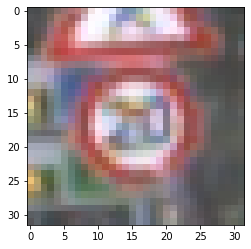

In [5]:
plt.imshow(X_train[0])

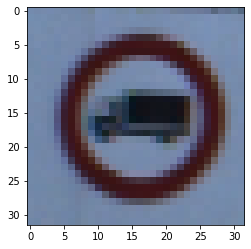

In [6]:
plt.imshow(X_test[0])

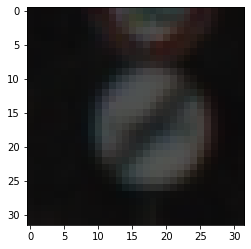

In [7]:
plt.imshow(X_valid[0])

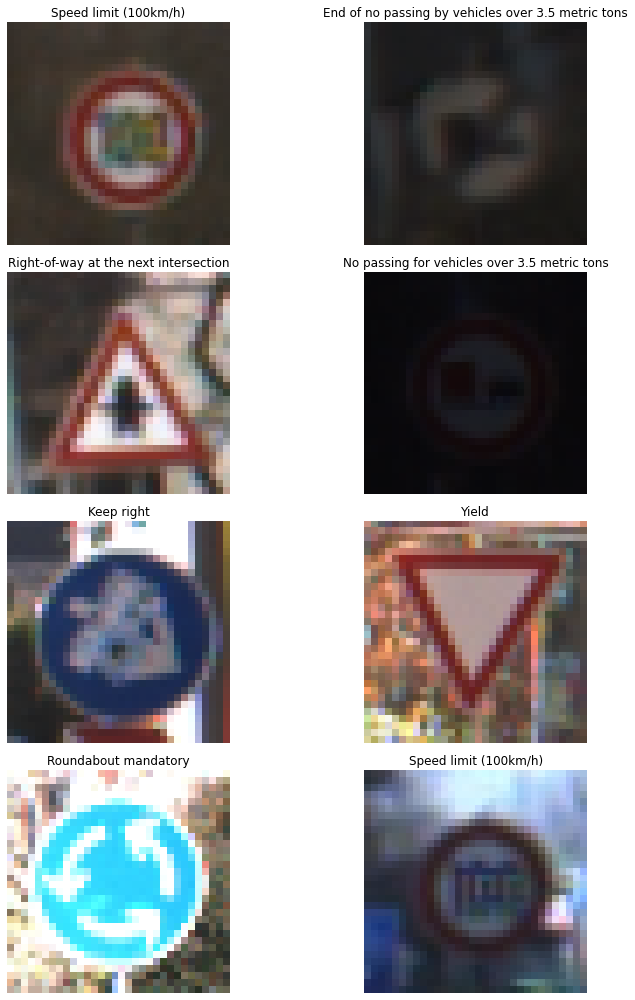

In [8]:
%matplotlib inline

def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
           axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
        
    plt.tight_layout()
    
name_values = np.genfromtxt('./traffic-signs-data/signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')
    
number_to_stop = 8
figures = {}
labels = {}
for i in range(number_to_stop):
    index = random.randint(0, n_train-1)
    labels[i] = name_values[y_train[index]][1].decode('ascii')
#     print(name_values[y_train[index]][1].decode('ascii'))
    figures[i] = X_train[index]

plot_figures(figures, 4, 2, labels)

# Preprocess the dataset

In [9]:
def normalize(image):
    normalized = (image.astype(np.float32) - 128) / 128
    return normalized

X_train = normalize(X_train)
X_train, y_train = shuffle(X_train, y_train)

## Label distribution

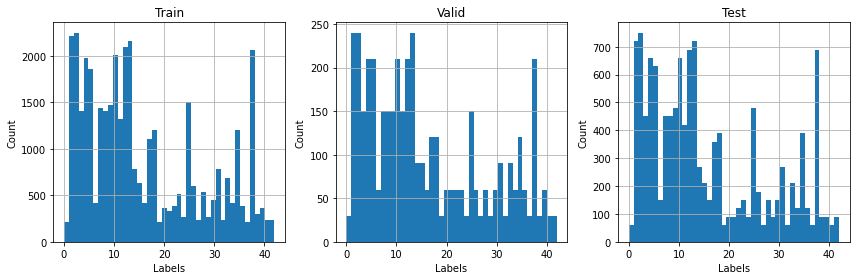

In [10]:
def plotLabelHistogram(labels, titles, number_of_labels):
    """
    Plot the histogram of the list of `labels` using the `titles` as title for the graphs
    and the number of bins `number_of_labels`.
    """
    nCols = len(labels)
    assert(nCols == len(titles))

    fig, axes = plt.subplots(ncols=nCols, figsize=(4*nCols, 4))
    for ax, label, title in zip(axes, labels, titles):
#         n, bins, patches = ax.hist(label, numberOfLabels, normed=1)
        n, bins, patches = ax.hist(label, numberOfLabels)
        ax.set_xlabel('Labels')
        ax.set_ylabel('Count')
        ax.set_title(title)
        ax.grid(True)

    fig.tight_layout()
    plt.show()

plotLabelHistogram([y_train, y_valid, y_test], ['Train', 'Valid', 'Test'], n_classes)

# Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Rotation')

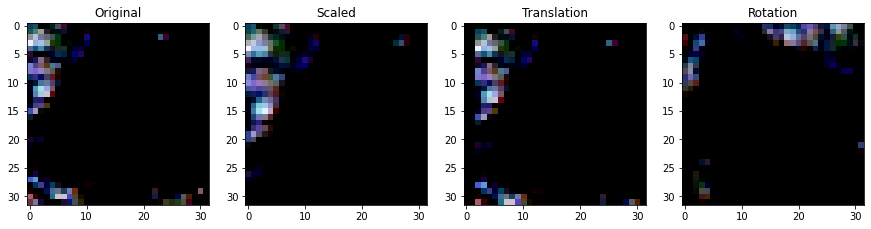

In [11]:
def transform(img, type = 0):
    if type == 0:
        fx = random.uniform(1.0, 1.3)
        fy = random.uniform(1.0, 1.3)
        return cv2.resize(img,None,fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)[0:32, 0:32,:]

    if type == 1: # Translation
        rY = random.randint(-5, 5)
        rX = random.randint(-5, 5)
        M = np.float32([[1,0,rY],[0,1,rX]])
    else:
        angle = random.randint(-90, 90)
        M = cv2.getRotationMatrix2D((16,16),angle,1)

    return cv2.warpAffine(img,M,(32,32))

fig, axes = plt.subplots(ncols=4, figsize=(15,10))
randomIndex = random.randint(0, len(X_train))
axes[0].imshow(X_train[randomIndex])
axes[0].set_title('Original')
axes[1].imshow(transform(X_train[randomIndex], 0))
axes[1].set_title('Scaled')
axes[2].imshow(transform(X_train[randomIndex], 1))
axes[2].set_title('Translation')
axes[3].imshow(transform(X_train[randomIndex], 2))
axes[3].set_title('Rotation')

/var/folders/dc/x1b4qsr974bd7_xwt2962q_c0000gn/T/ipykernel_61246/241330783.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, _ = np.histogram(input_labels, 43, normed=True)


New images count 80451


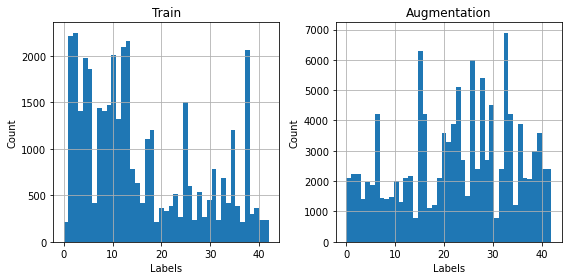

In [12]:
def generateImages(input, input_labels):
    hist, _ = np.histogram(input_labels, 43, normed=True)
    selectedLabel = []
    for index, v in enumerate(hist):
        if v < 0.02:
            selectedLabel.append(index)
    newInput = []
    newLabels = []
    for index, label in enumerate(input_labels):
        if label in selectedLabel:
            for i in range(0,9):
                type = random.randint(0, 3)
                newLabels.append(label)
                newInput.append(transform(input[index], type))
    
    return (np.array(newInput), np.array(newLabels))

X_train_new, y_train_new = generateImages(X_train, y_train)
print('New images count {}'.format(len(X_train_new)))
added = np.concatenate((y_train, y_train_new), axis=0)
plotLabelHistogram([y_train, added], ['Train', 'Augmentation'], n_classes)
X_train = np.concatenate((X_train, X_train_new), axis=0)
y_train = np.concatenate((y_train, y_train_new), axis=0)

## Model Architecture

In [13]:
def LeNet(x):    
    mu = 0
    sigma = 0.1

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    fc0   = flatten(conv3)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1    = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2    = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

# Train, Validate and Test the Model

In [14]:
EPOCHS = 25
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,  n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.00070

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/Users/vsivanandharao/Library/Python/3.9/lib/python/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/Users/vsivanandharao/Library/Python/3.9/lib/python/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [15]:
%%time

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    validation_accuracy_figure = []
    train_accuracy_figure = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_figure.append(validation_accuracy)

        train_accuracy = evaluate(X_train, y_train)
        train_accuracy_figure.append(train_accuracy)
        print("EPOCH {}".format(i+1))
        print("Train Accuracy = {:.2f} %".format(train_accuracy * 100))
        print("Validation Accuracy = {:.2f} %".format(validation_accuracy * 100))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

2022-09-11 17:48:41.322173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training...

EPOCH 1
Train Accuracy = 64.97 %
Validation Accuracy = 58.30 %

EPOCH 2
Train Accuracy = 81.06 %
Validation Accuracy = 77.94 %

EPOCH 3
Train Accuracy = 87.35 %
Validation Accuracy = 82.15 %

EPOCH 4
Train Accuracy = 92.81 %
Validation Accuracy = 90.43 %

EPOCH 5
Train Accuracy = 94.89 %
Validation Accuracy = 91.93 %

EPOCH 6
Train Accuracy = 95.66 %
Validation Accuracy = 93.36 %

EPOCH 7
Train Accuracy = 97.24 %
Validation Accuracy = 94.65 %

EPOCH 8
Train Accuracy = 97.46 %
Validation Accuracy = 93.08 %

EPOCH 9
Train Accuracy = 98.41 %
Validation Accuracy = 94.04 %

EPOCH 10
Train Accuracy = 98.45 %
Validation Accuracy = 95.24 %

EPOCH 11
Train Accuracy = 98.61 %
Validation Accuracy = 95.08 %

EPOCH 12
Train Accuracy = 99.10 %
Validation Accuracy = 96.03 %

EPOCH 13
Train Accuracy = 98.89 %
Validation Accuracy = 95.26 %

EPOCH 14
Train Accuracy = 99.29 %
Validation Accuracy = 96.46 %

EPOCH 15
Train Accuracy = 99.36 %
Validation Accuracy = 95.92 %

EPOCH 16
Train Accura

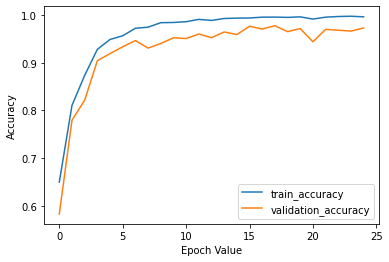

In [16]:
plt.plot(train_accuracy_figure, label='train_accuracy')
plt.plot(validation_accuracy_figure, label='validation_accuracy')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.legend(frameon=True)
plt.show()

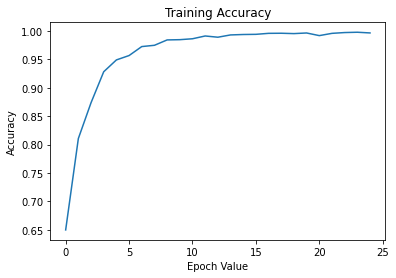

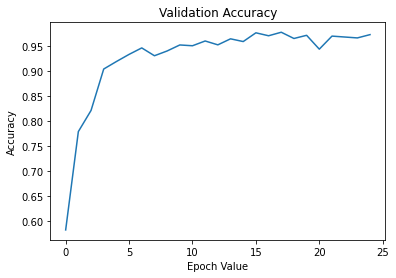

In [17]:
plt.plot(train_accuracy_figure)
plt.title("Training Accuracy")
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.show()

plt.plot(validation_accuracy_figure)
plt.title("Validation Accuracy")
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.show()

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.2f}".format(train_accuracy * 100))
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Valid Accuracy = {:.3f}".format(valid_accuracy * 100))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy * 100))

INFO:tensorflow:Restoring parameters from ./lenet
Train Accuracy = 99.64
Valid Accuracy = 97.302
Test Accuracy = 87.664


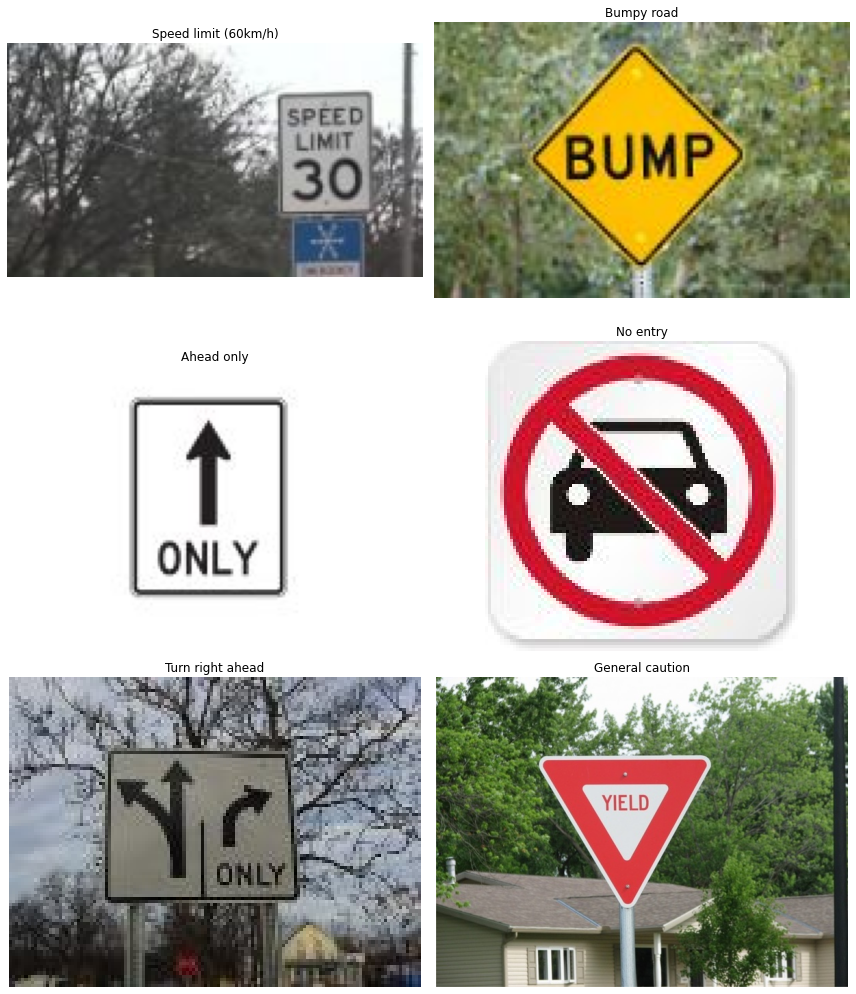

In [19]:
my_images = sorted(glob.glob('./test-images/*.jpg'))
my_labels = np.array([3, 22, 35, 17, 33, 18])

figures = {}
labels = {}
my_signs = []
for index, my_image in enumerate(my_images):
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')

plot_figures(figures, 3, 2, labels)